In [57]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import experiments.toy_regression as exp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device("cpu")

In [4]:
batch_size = 20
noise = torch.tensor(0.02).to(device) # 3, 0.02
layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 1))
]
learn_var = False

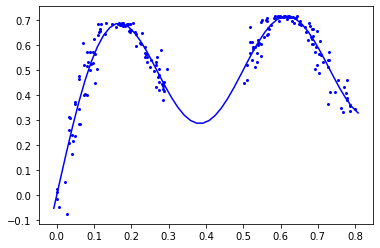

In [9]:
from training import toy
import matplotlib.pyplot as plt

torch.manual_seed(42)

trainset = toy.TrigonometricToyDataset(sample_count=200, noise=0.02, normalize=False, max=0.8, skip=0.2)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

axis = plt.subplot()
trainset.plot_dataset(axis)

In [58]:
torch.manual_seed(42)
gp, gp_true_lml = exp.gaussian_process(100, trainset.normalized_xs, trainset.normalized_ys, variance=torch.tensor(0.02))

Epoch 0: loss -0.6137326955795288
Epoch 20: loss -0.8570775389671326
Epoch 40: loss -0.8684059977531433
Epoch 60: loss -0.8740665316581726
Epoch 80: loss -0.876422643661499


C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Foo


C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo


C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo
Foo


C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


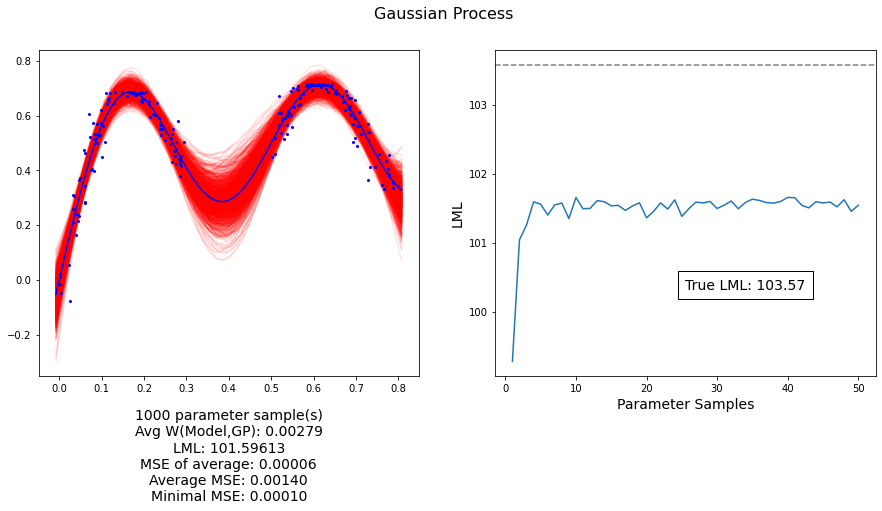

In [59]:
trainset.plot("Gaussian Process", gp, gp, alpha=0.1, samples=1000, plot_lml_trend=(50, 50), gp_lml=gp_true_lml, variance=torch.tensor(0.02))

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\models\exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


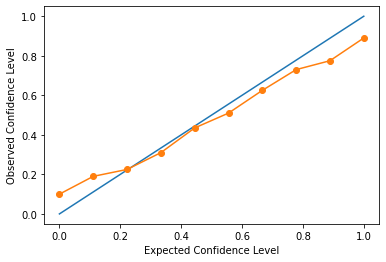

In [51]:
exp.plot_calibration(gp, trainset.xs, trainset.ys, 100, 10)

In [12]:
torch.manual_seed(42)
from training.pp import PointPredictor
pp = PointPredictor(layers)
pp.train(900, torch.nn.MSELoss(), torch.optim.SGD(pp.parameters(), lr=0.1), trainloader, batch_size, device, report_every_epochs=100)
#pp = exp.point_estimator(layers, noise, learn_var, 900, trainloader, batch_size, device)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
2209 trainable parameters
Epoch 0: loss 0.00422613974660635
Epoch 100: loss 0.000969829095993191
Epoch 200: loss 0.0005992611986584961
Epoch 300: loss 0.0005091184284538031
Epoch 400: loss 0.00043986522359773517
Epoch 500: loss 0.00041091832099482417
Epoch 600: loss 0.0004007518582511693
Epoch 700: loss 0.00033283288939855993
Epoch 800: loss 0.0002324391098227352
Final loss 0.00018323578115087003


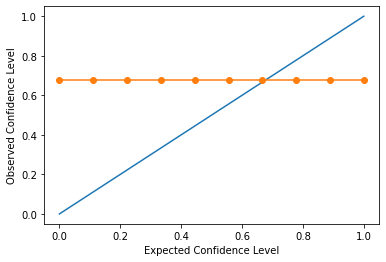

In [13]:
exp.plot_calibration(pp.infer, torch.unsqueeze(trainset.xs, -1), torch.unsqueeze(trainset.ys, -1), 100, 10)

In [25]:
torch.manual_seed(42)
from training.swag import SwagModel
swag_config = {
    "start_epoch": 700,
    "update_every_batches": len(trainloader),
    "deviation_samples": 50
}
swag = SwagModel(layers, swag_config)
swag.train(900, torch.nn.MSELoss(), torch.optim.SGD(swag.parameters(), lr=0.1), trainloader, batch_size, device, report_every_epochs=100)
#swag = exp.swag(layers, noise, learn_var, 900, swag_config, trainloader, batch_size, device)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
2209 trainable parameters
Epoch 0: loss 0.00422613974660635
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss 0.000969829095993191
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 200: loss 0.0005992611986584961
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 300: loss 0.0005091184284538031
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 400: loss 0.00043986522359773517
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 500: loss 0.00041091832099482417
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 600: loss 0.00040075

In [72]:
torch.manual_seed(42)
ensemble = exp.ensemble(5, layers, noise, learn_var, 900, trainloader, batch_size, parallel=False)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)
Generated model: Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1)

In [9]:
torch.manual_seed(42)
mc_dropout = exp.mc_dropout(0.1, layers, noise, learn_var, 900, trainloader, batch_size)

Generated model: Sequential(
  (0): Linear(in_features=1, out_features=35, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=35, out_features=35, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=35, out_features=35, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=35, out_features=1, bias=True)
)
Epoch 0: loss -0.04623353108763695
Epoch 100: loss -0.08249913901090622
Epoch 200: loss -0.08788342773914337
Epoch 300: loss -0.08822451531887054
Epoch 400: loss -0.09039641171693802
Epoch 500: loss -0.08920774608850479
Epoch 600: loss -0.08926518261432648
Epoch 700: loss -0.09027083218097687
Epoch 800: loss -0.0911581963300705
Final loss -0.09162870049476624


In [13]:
from training.bbb import GaussianPrior, BBBModel

torch.manual_seed(42)
bbb_prior = GaussianPrior(0, 1)
bbb = BBBModel(bbb_prior, "activations", layers)
bbb.train(900, torch.nn.MSELoss(reduction="sum"), torch.optim.SGD(bbb.parameters(), lr=0.1), trainloader, batch_size, device, report_every_epochs=50, kl_rescaling=5)
#bbb = exp.bbb(layers, noise, learn_var, 1000, trainloader, batch_size, device, kl_rescaling=5)

Generated model: Sequential(
  (0): BBBLinear()
  (1): ReLU()
  (2): BBBLinear()
  (3): ReLU()
  (4): BBBLinear()
  (5): ReLU()
  (6): BBBLinear()
)
4418 trainable parameters
Epoch 0: loss 135.1353302001953
Epoch 50: loss 2.8154385089874268
Epoch 100: loss 2.7348785400390625
Epoch 150: loss 3.1879820823669434
Epoch 200: loss 2.666738510131836
Epoch 250: loss 2.7779645919799805
Epoch 300: loss 2.8520095348358154
Epoch 350: loss 2.910362958908081
Epoch 400: loss 2.7683298587799072
Epoch 450: loss 2.9946465492248535
Epoch 500: loss 2.7811083793640137
Epoch 550: loss 2.971586227416992
Epoch 600: loss 3.017418146133423
Epoch 650: loss 2.763085126876831
Epoch 700: loss 2.8657212257385254
Epoch 750: loss 2.824995994567871
Epoch 800: loss 3.1023647785186768
Epoch 850: loss 2.7085354328155518
Final loss 3.0353052616119385


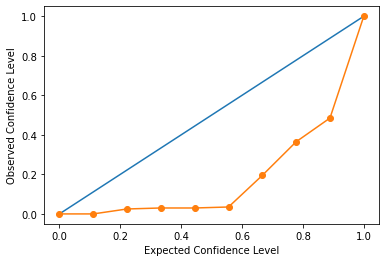

In [15]:
exp.plot_calibration(bbb.infer, torch.unsqueeze(trainset.xs, -1), torch.unsqueeze(trainset.ys, -1), 100, 10)

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\likelihoods\gaussian_likelihood.py:270: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorc

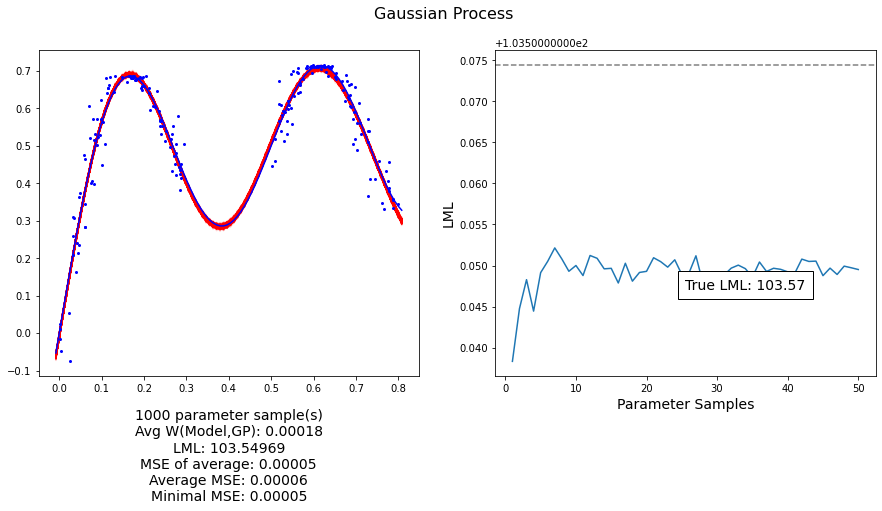

In [56]:
trainset.plot("Gaussian Process", gp, gp, alpha=0.1, samples=1000, plot_lml_trend=(50, 50), gp_lml=gp_true_lml, variance=torch.tensor(0.02))

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


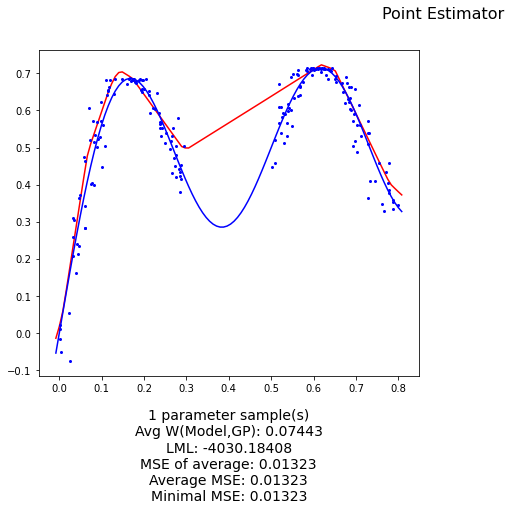

In [16]:
trainset.plot("Point Estimator", pp.infer, gp, noise, alpha=1, samples=1)

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


[(tensor([-0.0219,  0.0212,  0.0702,  0.1181,  0.1679,  0.2150,  0.2673,  0.3161,
         0.3646,  0.4130,  0.4575,  0.4982,  0.5355,  0.5722,  0.5991,  0.6264,
         0.6511,  0.6698,  0.6814,  0.6916,  0.6953,  0.6962,  0.6931,  0.6861,
         0.6780,  0.6651,  0.6500,  0.6329,  0.6142,  0.5914,  0.5716,  0.5460,
         0.5219,  0.5005,  0.4776,  0.4519,  0.4330,  0.4125,  0.3934,  0.3745,
         0.3579,  0.3423,  0.3315,  0.3213,  0.3126,  0.3083,  0.3040,  0.3040,
         0.3047,  0.3073,  0.3125,  0.3201,  0.3324,  0.3438,  0.3587,  0.3746,
         0.3934,  0.4104,  0.4348,  0.4559,  0.4791,  0.5021,  0.5240,  0.5468,
         0.5702,  0.5906,  0.6143,  0.6324,  0.6496,  0.6656,  0.6812,  0.6916,
         0.7010,  0.7086,  0.7113,  0.7146,  0.7105,  0.7063,  0.6974,  0.6882,
         0.6764,  0.6601,  0.6429,  0.6249,  0.6051,  0.5833,  0.5618,  0.5377,
         0.5162,  0.4957,  0.4747,  0.4547,  0.4374,  0.4209,  0.4075,  0.3987,
         0.3882,  0.3831,  0.3818,  0.

TypeError: expected Tensor as element 0 in argument 0, but got tuple

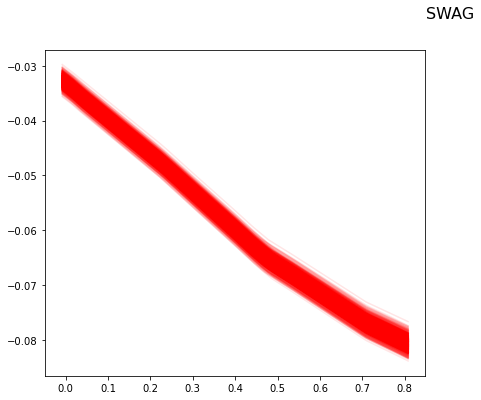

In [23]:
trainset.plot("SWAG", swag.infer, gp, alpha=0.1, samples=1000, plot_lml_trend=(50, 50), variance=torch.tensor(0.02))

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


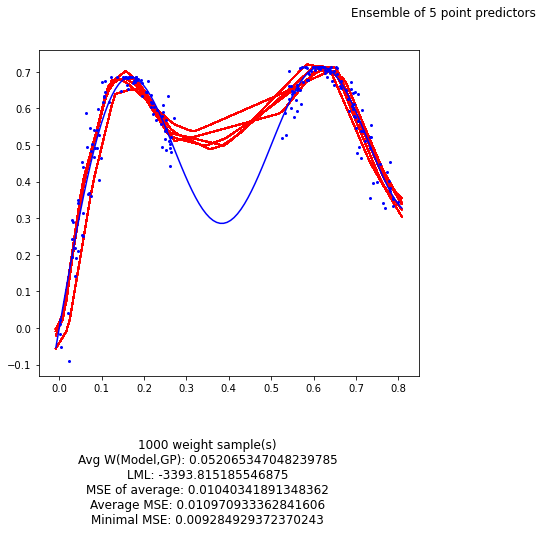

In [73]:
trainset.plot("Ensemble of 5 point predictors", ensemble, gp, alpha=0.1, samples=1000)

C:\Users\flose\.conda\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


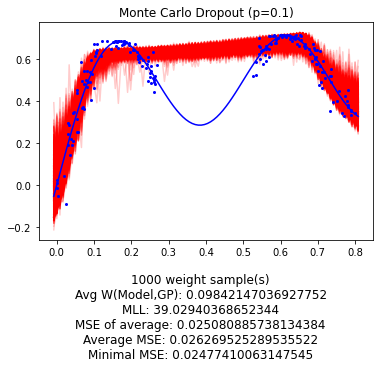

In [14]:
trainset.plot("Monte Carlo Dropout (p=0.1)", mc_dropout, gp, alpha=0.2, samples=1000)

C:\Users\flose\anaconda3\envs\ml\lib\site-packages\gpytorch\utils\cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


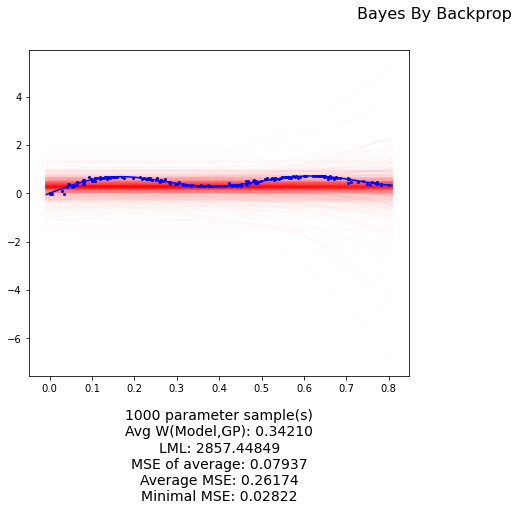

In [14]:
trainset.plot("Bayes By Backprop", bbb.infer, gp, alpha=0.01, samples=1000, variance=torch.tensor(0.02))